## 构建信用评分预测分类模型

---

本次挑战中，你将使用信用评分数据构建模型并回答问题。

### 信用评分预测任务

#### 问题

信用评分预测任务是一个二元分类问题，主要是预测用户是否会在 90 天内偿还信用借款。

数据集结构示例如下：

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |

SeriousDlqin2yrs 即为目标值，0 代表正常偿还，1 代表延迟偿还。

下面，我们导入本次挑战所需相关模块：

In [1]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

我们编写一个函数，使用每列数据的中位数替换 NaN 空值。

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

现在，读取并预览数据集。

In [4]:
data = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/credit_scoring_sample.csv', sep=';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


查看各列变量类型：

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

通过绘图检查类别是否均衡：

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

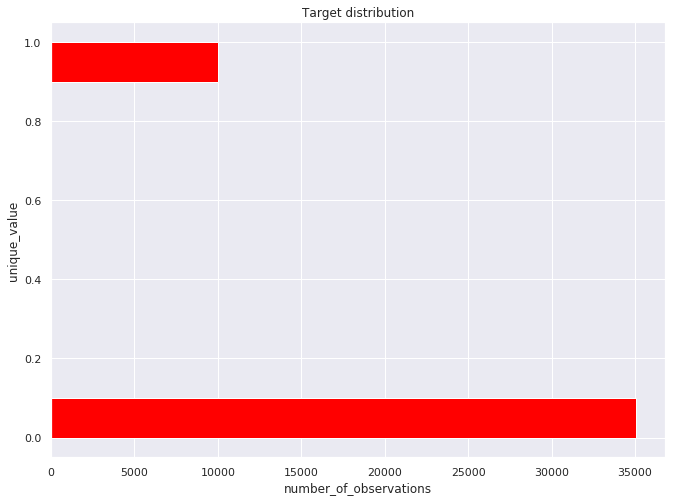

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

这里，分离出数据特征列名称：

In [7]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

使用预先定义好的缺失值处理函数来填充缺失特征数据。

In [8]:
table = fill_nan(data)

最后，将特征数据和目标值分离并赋值：

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']
X.shape, y.shape

((45063, 7), (45063,))

### 区间估计

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>对延迟还款的客户的平均年龄进行间隔估计，置信水平设为 90％。区间估计结果是多少？

你可以使用文章中的示例作为参考，并需指定 `np.random.seed(0)`。

- [ A ] 52.59 – 52.86
- [ B ] **45.71 – 46.13**
- [ C ] 45.68 – 46.17
- [ D ] 52.56 – 52.88

In [10]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


# Save the ages of those who let a delay
churn = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# Set the random seed for reproducibility
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample)
                     for sample in get_bootstrap_samples(churn, 1000)]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.71379414 46.12700479]


### 逻辑回归分类器

下面，挑战建立逻辑回归分类预测模型。

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

现在，我们将创建一个 LogisticRegression 模型，并使用 `class_weight ='balanced'` 来弥补数据中不平衡类。

In [12]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

让我们试着找到模型最佳正则化系数，该系数在逻辑回归中由 C 系数指定，其作用是得到一个不过度拟合的最优模型。下面给出几个 C 参数的备选项。

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01)}

为了找到最佳 C 值，让我们使用 `StratifiedKFold` 分层采样交叉验证，以确保训练集、测试集中各类别样本的比例与原始数据集中相同。

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

本次模型质量评估选用曲线下面积（AUC）指标。AUC 值介于 0 到 1 之间，接近 1 则表示分类模型的质量越好。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>请使用 `scoring='roc_auc'` 作为评估指标，并运用 Grid Search 方法来搜索最佳 C 参数，最优值为多少？

- [ A ] 0.0001
- [ B ] **0.001**
- [ C ] 0.01
- [ D ] 0.1
- [ E ] 1
- [ F ] 10

In [15]:
grid_search = GridSearchCV(lr, parameters, n_jobs=-1,
                           scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

模型最佳 ROC AUC 值为：

In [16]:
grid_search.best_score_

0.7954977787123253

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>如果模型测试集上的标准差小于 0.005，则认为模型是稳定的。上面得到的最佳 C 值能否保证模型稳定？

- [ A ] Yes
- [ B ] **No**

In [17]:
grid_search.cv_results_['std_test_score'][1]

0.0063814493813616775

### 特征重要性

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>特征重要性由其相应系数的绝对值定义。首先，您需要使用 `StandardScaler` 规范化所有特征值以便于正确比较。那么，上面得到的最佳逻辑回归模型中，哪个特征最为重要？

- [ A ] age
- [ B ] **NumberOfTime30-59DaysPastDueNotWorse**
- [ C ] DebtRatio
- [ D ] NumberOfTimes90DaysLate
- [ E ] NumberOfTime60-89DaysPastDueNotWorse
- [ F ] MonthlyIncome
- [ G ] NumberOfDependents

In [18]:
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()  # 规范化
lr.fit(scal.fit_transform(X), y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004
3,NumberOfTimes90DaysLate,0.517673
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732
6,NumberOfDependents,0.101326
2,DebtRatio,-0.024082
5,MonthlyIncome,-0.162864
0,age,-0.416304


### 随机森林

接下来，我们构建随机森林分类预测模型，首先导入所需类。

In [19]:
from sklearn.ensemble import RandomForestClassifier

初始化 100 颗决策树并同样使用类别平衡。

In [20]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42,
                            class_weight='balanced')

接下来，从以下候选参数中进行网格搜索。

In [21]:
# parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]}
# 为了加快搜索速度，这里仅保留原参数中的最佳参数
parameters = {'max_features': [2], 'min_samples_leaf': [7], 'max_depth': [10]}

同样，这里为了找到最佳参数值，使用 `StratifiedKFold` 分层采样交叉验证。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>使用随机森林方法得到的最佳参数比上文中逻辑回归最佳参数在 ROC AUC 指标上高多少？

- [ A ] **4%**
- [ B ] 3%
- [ C ] 2%
- [ D ] 1%

In [22]:
rf_grid_search = GridSearchCV(
    rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)

rf_grid_search.best_score_ - grid_search.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


0.03955801993178054

In [23]:
rf_grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>随机森林方法最优模型中，特征重要性最弱的是拿一项？

- [ A ] age
- [ B ] NumberOfTime30-59DaysPastDueNotWorse
- [ C ] DebtRatio
- [ D ] NumberOfTimes90DaysLate
- [ E ] NumberOfTime60-89DaysPastDueNotWorse
- [ F ] MonthlyIncome
- [ G ] **NumberOfDependents**

In [24]:
independent_columns_names[np.argmin(
    rf_grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

In [25]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': rf_grid_search.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.302461
3,NumberOfTimes90DaysLate,0.278644
4,NumberOfTime60-89DaysPastDueNotWorse,0.148683
0,age,0.115926
2,DebtRatio,0.079520
5,MonthlyIncome,0.060429
6,NumberOfDependents,0.014337


<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>对于挑战数据集，Logistic 回归相比于随机森林最显着优势是什么？

- [ A ] 花费更少的时间进行模型拟合。
- [ B ] 迭代的变量较少。
- [ C ] **特征可解释性。**
- [ D ] 算法的线性属性。

一方面，随机森林模型更适合信用评分问题。它的性能比逻辑回归提高了 4％。另一方面，Logistic 回归的主要优点是我们可以解释特征对模型结果的影响。

---

<div style="background-color: #e6e6e6; margin-bottom: 10px; padding: 1%; border: 1px solid #ccc; border-radius: 6px;text-align: center;"><a href="https://nbviewer.jupyter.org/github/shiyanlou/mlcourse-answers/tree/master/" title="挑战参考答案"><i class="fa fa-file-code-o" aria-hidden="true"> 查看挑战参考答案</i></a></div>